<a href="https://colab.research.google.com/github/lollipopenator/Manning/blob/master/Pose_Estimation_2_Intro_to_CNNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following Tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py


Some other models I looked at:

https://github.com/potterhsu/SVHNClassifier-PyTorch/blob/master/model.py (I used hyperparameters from here)

https://github.com/blaueck/pytorch-demo/blob/master/models/simple_cnn.py


# Start SVHN

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

import logging
logging.basicConfig()

# creates a new logger called 'SVHN_logger'
# Future calls to getLogger with this name will always return the same instance,
svhn_logger = logging.getLogger('SVHN_logger')

######## Select an option below for logging level ########
# The loggoinmg level can also be set later in the code,  just prior to where
# you want to  enable logging.
# 
# svhn_logger.setLevel(logging.DEBUG) 
# the above will log all messages (DEBUG, INFO, WARNING, ERROR, CRITICAL)


svhn_logger.setLevel(logging.INFO) 
# the above will only log messages at level INFO and higher (basically shuts off all my
# verbose debug output)



In [0]:
# download the train and test datasets
# !wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
# !wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat



Setup Transforms

The below is from https://forums.fast.ai/t/image-normalization-in-pytorch/7534

https://forums.fast.ai/t/image-normalization-in-pytorch/7534/6




---

  The code below is inspired by code found in this post:
  https://forums.fast.ai/t/image-normalization-in-pytorch/7534/7
  

  wsl_na may also need to divide by 255 as per here: https://forums.fast.ai/t/image-normalization-in-pytorch/7534/9


In [0]:
# Helper function for precalculating the per-channel means and stds over the 
# entire dataset
def get_dataset_mean_and_std():
  img_transform = transforms.ToTensor() 

  # Load the trainset for the purpose of calculating the per-channel mean and std
  # over the entire trainset. 
  # We will pass these values (dataset mean/std) into 
  # the per-image transform when we later load the testset to do some actual 
  # work.
  # On this first load of the data we only use the ToTensor() transform 
  # and no other transforms, as the whole point of this bit is to find the values 
  # we are going to use later in the per-image transform.
  trainset = torchvision.datasets.SVHN(root='/content', split='train', 
                                    transform=transforms.ToTensor(),
                                    download=True)

  svhn_logger.debug('In get_dataset_mean_and_std(): loaded testset to calculate per-dataset mean and std...')

  import numpy as np


  loader = torch.utils.data.DataLoader(trainset, batch_size=4096, shuffle=False, num_workers=4)

  pop_mean = []
  pop_std0 = []

  for i, data in enumerate(loader, 0):

      # shape (batch_size, 3, height, width)
      numpy_image = data[0].numpy()
      
      # shape (3,)
      batch_mean = np.mean(numpy_image, axis=(0,2,3))
      batch_std0 = np.std(numpy_image, axis=(0,2,3))
  
      
      pop_mean.append(batch_mean)
      pop_std0.append(batch_std0)
  

  # # shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
  pop_mean = np.array(pop_mean).mean(axis=0)
  pop_std0 = np.array(pop_std0).mean(axis=0)

  svhn_logger.debug('len(trainset): %s', len(trainset))
  svhn_logger.debug('len(trainset)/batch_size: %s', len(trainset)/4096)
  svhn_logger.debug('i: %s', i)
  svhn_logger.debug('pop_mean: %s', pop_mean)
  svhn_logger.debug('pop_std0: %s', pop_std0)

  svhn_logger.info('Finished calulating per-channel means and stds over entire testset...')
  return ({'mean': pop_mean, 'std': pop_std0})


Create dataset using transforms, then create dataloader,  and also do a couple of quick tests/views of data

In [0]:
# wsl_na check what 'shuffle' value is best

# wsl revert to batch_size = 4 when ready. 
my_batch_size = 4

# now that we have the per-channel mean and std over the entire dataset, we
# can pass it into the Normalize(..) transform which will be applied to each 
# image as it is loaded.
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(**get_dataset_mean_and_std())
])

######## Training Data
trainset = torchvision.datasets.SVHN(root='/content', split='train', 
                                    transform=img_transform, target_transform=None,
                                    download=True)
svhn_logger.info('created trainset')
trainloader = torch.utils.data.DataLoader(trainset, batch_size = my_batch_size,
                                         shuffle=True, num_workers=2)
svhn_logger.info('created trainloader')


######## Test Data
testset = torchvision.datasets.SVHN(root='/content', split='test', 
                                    transform=img_transform, target_transform=None,
                                    download=True)
svhn_logger.info('created testset')
testloader = torch.utils.data.DataLoader(testset, batch_size = my_batch_size,
                                         shuffle=True, num_workers=2)
svhn_logger.info('created testloader')

INFO:SVHN_logger:Finished calulating per-channel means and stds over entire testset...


Using downloaded and verified file: /content/train_32x32.mat


INFO:SVHN_logger:created trainset
INFO:SVHN_logger:created trainloader


INFO:SVHN_logger:created testset
INFO:SVHN_logger:created testloader



These means are over the entire image, rather than per RGB color-channel
However they still give a general idea whether the values are between 
approximately -3 and +3, which is where they ought to be after standardisation.

See ie https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

image_info: img.shape: %s torch.Size([3, 32, 32])
image_info: img.shape: %s torch.Size([3, 32, 32])
image_info: img.shape: %s torch.Size([3, 32, 32])
image_info: img.shape: %s torch.Size([3, 32, 32])


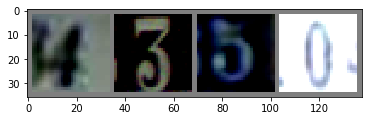

GroundTruth:  tensor(4) tensor(3) tensor(5) tensor(0)


In [0]:
import matplotlib.pyplot as plt
import numpy as np
# matplotlib was giving too many info- and debug- level logs.
# grab an instance of its logger and set it to warnings only.
logging.getLogger(plt.__name__).setLevel(logging.WARNING)


# functions to show an image and to provide general info about it
def imshow(img):
    img = img / 2 + 0.5     # roughly unnormalize # wsl maybe fix
    img = img.cpu() # Needed when running on GPU
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def image_info(img):
    # Main info about this image
    print('image_info: img.shape: %s', img.shape)

    # additional info which may sometimes be needed is below
    # these means are over the entire image, rather than per RGB color-channel
    # (see notes above as to why)
    svhn_logger.debug('image_info: img.mean(): %s', img.mean())
    svhn_logger.debug('image_info: ----------------------------------img.min(): %s', img.min())
    svhn_logger.debug('image_infoL----------------------------------------------------------------img.max(): %s', img.max())

    # uncomment to show the mean per RGB channel
    # logger.debug('image_info: img.mean(): %s', img.mean(axis=(1,2)))


# get some random training images and display them (and associated labels)
dataiter = iter(trainloader)
images, labels = dataiter.next()


for image in images:
  image_info(image)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(my_batch_size))) # wsl revert to 4


## 2. Define a Convolutional Neural Network

https://discuss.pytorch.org/t/is-there-similar-pytorch-function-as-model-summary-as-keras/2678/5

How to work out the correct parameters for the fc layer at the end.:
```
from torchsummary import summary
summary(net, (3, 32, 32))
```

where (3, 32, 32) is the input shape, which needs to be known in advance. The output size of the following layers given this input will be displayed by the summary(..) call, in the same format as that used in KERAS.


---

https://pytorch.org/docs/stable/nn.html#batchnorm2d

See also discussion here:
https://discuss.pytorch.org/t/example-on-how-to-use-batch-norm/216


---

I tried out hyper-parameters from first three layers of networks here:
 https://github.com/potterhsu/SVHNClassifier-PyTorch/blob/master/model.py
 https://github.com/blaueck/pytorch-demo/blob/master/models/simple_cnn.py



In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [0]:
import torch.nn as nn
import torch.nn.functional as F



# wsl_na
# Initialize the weights of the convolutioanl layers with a normal distribution 
# with std=0.001, and their biases with a constant value of 0
# wsl_na move to gpu

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Three convolutional layers with batchnorm, maxpooling, and 
        # ReLU activation.
        self._hidden1 = nn.Sequential(
            nn.Conv2d(kernel_size=5, in_channels=3, out_channels=48, stride=1, padding=4),
            nn.BatchNorm2d(num_features=48),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(0.2)
        )
        self._hidden2 = nn.Sequential(
            nn.Conv2d(kernel_size=3, in_channels=48, out_channels=64, stride=1, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # nn.Dropout(0.2)
        )
        self._hidden3 = nn.Sequential(
            nn.Conv2d(kernel_size=3, in_channels=64, out_channels=128, stride=1, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # nn.Dropout(0.2)
        )

        # A single fully-connected layer at the end  
        self.fc = nn.Linear(128 * 6 * 6, 10)
       

        

    def forward(self, x):

        x = self._hidden1(x)
        x = self._hidden2(x)
        x = self._hidden3(x)

        x = x.view(-1, 128 * 6 * 6)
        x = self.fc(x)
        return x


net = Net()


# from torchsummary import summary
# summary(net, (3, 32, 32))



## 3. Define a Loss function and optimizer

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


## 4. Train the network

In [0]:


# Training Loop: Now it is time to define the training procedure. Again, you can follow closely the pytorch tutorial:

# loss function: Use Softmax-Crossentropy (torch.nn.CrossEntropyLoss) for classification
# optimizer: the Adam optimizer is often a good starting point.

# Print out the loss periodically, so you can monitor the training progress. For bigger tasks, you can look into Tensorboard but for our project, we won’t need it.

# Also calculate the accuracy on the testset periodically. Sometimes the loss does not decrease, but the accuracy still improves.

# Learning rate: Try to find a good learning rate. If it is too big, your loss will increase. If it’s too small, your loss will decrease very slowly or not at all.
# Decreasing the learning rate after a few epochs sometimes gives a small boost in the model accuracy.

# Batch-size: Generally, the bigger the better. It is usually limited by the GPU memory

# Make sure you move the model, the images and the labels to the GPU memory with xx.to(‘cuda’) AND you run model.train() and model.eval() when needed.
net.to(device)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.721
[1,  4000] loss: 0.719
[1,  6000] loss: 0.578
[1,  8000] loss: 0.507
[1, 10000] loss: 0.469
[1, 12000] loss: 0.439
[1, 14000] loss: 0.424
[1, 16000] loss: 0.402
[1, 18000] loss: 0.375
[2,  2000] loss: 0.330
[2,  4000] loss: 0.326
[2,  6000] loss: 0.339
[2,  8000] loss: 0.314
[2, 10000] loss: 0.316
[2, 12000] loss: 0.308
[2, 14000] loss: 0.307
[2, 16000] loss: 0.325
[2, 18000] loss: 0.327
Finished Training


## 4a. Save the Model.

In [0]:

PATH = '/content/svhn.net'
torch.save(net.state_dict(), PATH)


# 5. Test the network on the test data

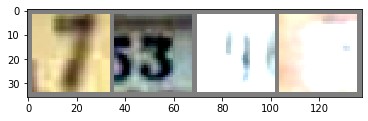

GroundTruth:  tensor(7, device='cuda:0') tensor(3, device='cuda:0') tensor(9, device='cuda:0') tensor(3, device='cuda:0')


In [0]:
dataiter = iter(testloader)
# images, labels = dataiter.next()
data = dataiter.next()
images, labels = data[0].to(device), data[1].to(device)

# wsl_na fix this!
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

Load the saved model back in ( (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [0]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

In [0]:
# Okay, now let us see what the neural network thinks these examples above are:


outputs = net(images)
# The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(my_batch_size)))

Predicted:  tensor(7, device='cuda:0') tensor(3, device='cuda:0') tensor(9, device='cuda:0') tensor(1, device='cuda:0')


In [0]:
# The results seem pretty good.

# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# print('Accuracy of the network on the 10000 test images: %2d %%' % (
#     100 * correct / total))

print('Accuracy of the network on the %s  test images: %.2f %%' % (len(testset),
    100.0000 * correct / total))

Accuracy of the network on the 26032  test images: 90.15 %


# On which digits did the network perform best?

In [0]:
correct_per_class = list(0. for i in range(10))
total_per_class = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            correct_per_class[label] += c[i].item()
            total_per_class[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * correct_per_class[i] / total_per_class[i]))

Accuracy of     0 : 93 %
Accuracy of     1 : 95 %
Accuracy of     2 : 93 %
Accuracy of     3 : 80 %
Accuracy of     4 : 92 %
Accuracy of     5 : 92 %
Accuracy of     6 : 85 %
Accuracy of     7 : 87 %
Accuracy of     8 : 79 %
Accuracy of     9 : 90 %
